# Vehicle Detection and Tracking
- by NK Zou  

#### Table of content
1- Classifier  
2.1- Slide Window  
2.2- Heat Map  
3 - Pipeline  
4.1- Train Data or Load Classifier  
4.2- Debug  
4.3 - Process Video  

### 1- Classifier

In [1]:
import glob
import scipy.misc
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time

class Classifier(object):

### 1- Parameters
    cspace='HSV'
    spatial_size=(32, 32)
    hist_bins=32
    hist_range=(0, 256)
    orient=9
    pix_per_cell=8
    cell_per_block=2
    hog_channel=2
    spatial=True
    histogram=True
    hog_method=True
    vis = False
    feature_vec = True

### 2- Function Set

### Initialization
    def __init__(self):
        self.classifier = []
        self.scaler = []
        
### Run this function if data has been trained
    def load_dataset(self):
        cars = []
        notcars = []
        images = glob.iglob('vehicles/*/*.png', recursive=True)
        for image in images:
            cars.append(image)
        images = glob.iglob('non-vehicles/*/*.png', recursive=True)
        for image in images:
            notcars.append(image)
        return cars, notcars

### Create the feature vector for computes binned color features
    def spatial(self, img):
        return cv2.resize(img, self.spatial_size).ravel()

### Compute histogram of the color channels separately
### Concatenate histograms into a single feature vector, return individual histograms, bin_centers and feature vector
    def hist(self, img):
        channel1_hist = np.histogram(img[:, :, 0], bins=self.hist_bins, range=self.hist_range)
        channel2_hist = np.histogram(img[:, :, 1], bins=self.hist_bins, range=self.hist_range)
        channel3_hist = np.histogram(img[:, :, 2], bins=self.hist_bins, range=self.hist_range)
        return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    def hog(self, img_channel):
        if self.vis:
            return hog(img_channel, orientations=self.orient,
                       pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block, self.cell_per_block),
                       transform_sqrt=True, visualise=self.vis, feature_vector=self.feature_vec)
        else:
            return hog(img_channel, orientations=self.orient,
                       pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block, self.cell_per_block),
                       transform_sqrt=True, visualise=self.vis, feature_vector=self.feature_vec)

### extracts features from the given rgb image
### Combines color, histogram and hog features extraction
    def combined_features(self, rgb_image):
    ### Apply color conversion if other than 'RGB'
        features = []
        if self.cspace != 'RGB':
            if self.cspace == 'HSV':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
            elif self.cspace == 'LUV':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LUV)
            elif self.cspace == 'HLS':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
            elif self.cspace == 'YUV':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YUV)
            elif self.cspace == 'YCrCb':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(rgb_image)
    ### Extract spatial color features
        if self.spatial:
            features.append(self.spatial(feature_image))
        if self.histogram:
            features.append(self.hist(feature_image))
        if self.hog_method:
            if self.hog_channel == 'ALL':
                features.append(self.hog(feature_image[:, :, 0]))
                features.append(self.hog(feature_image[:, :, 1]))
                features.append(self.hog(feature_image[:, :, 2]))
            else:
                features.append(self.hog(feature_image[:, :, self.hog_channel]))
        return np.concatenate((features))

### Prepare for train data, extract features from all the images in the given list of files
    def extract_features(self, img_files):
        features = []
        for afile in img_files:
            rgb_image = scipy.misc.imread(afile)
            features.append(self.combined_features(rgb_image))
        return features

### Run this function at first time if data never been trained
    def train_classifier(self, cars, notcars):
        classifier_file = 'classifier.pkl'
        scaler_file = 'scaler.pkl'
        car_features = self.extract_features(cars)
        notcar_features = self.extract_features(notcars)
        x_data = np.vstack((car_features, notcar_features)).astype(np.float64)
        x_scaler = StandardScaler().fit(x_data)
        joblib.dump(x_scaler, scaler_file)
        scaled_x = x_scaler.transform(x_data)
        y_data = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        rand_state = np.random.randint(0, 100)
        x_train, x_test, y_train, y_test = train_test_split(scaled_x, y_data, test_size=0.2, random_state=rand_state)
    ### Select LinearSVC as classifier
        svc = LinearSVC()
        tstamp1 = time.time()
        svc.fit(x_train, y_train)
        tstamp2 = time.time()
        print('Trained in ', tstamp2-tstamp1, ' seconds.')
        print('Accuracy of training is ', svc.score(x_train, y_train))
        print('Accuracy of testing is ', svc.score(x_test, y_test))
        tstamp1 = time.time()
        prediction = svc.predict(x_test[0].reshape(1, -1))
        print("prediction", prediction)
        tstamp2 = time.time()
        print('Predicted in ', tstamp2-tstamp1, ' seconds.')
    ### Save classifier model
        joblib.dump(svc, classifier_file)
        self.classifier = svc
        self.scaler = x_scaler

### Run this function if data has been trained
    def load_classifier(self, classifier_file, scaler_file):
        self.classifier = joblib.load(classifier_file)
        self.scaler = joblib.load(scaler_file)

### Run this function to load classifier when predicting images
    def get_classifier(self):
        return self.classifier

### Run this function to load scaler when predicting images
    def get_scaler(self):
        return self.scaler

### 2.1- Slide Window

In [2]:
def window_slider(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64),
                  xy_overlap=(0.5, 0.5), max_y=780):
    height, width, channels = img.shape
### If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
### Compute the span of the searched region & the number of pixels per step in x/y & number of windows in x/y
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
### Append window positions
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
    ### Compute window position
            startx = int(xs*nx_pix_per_step + x_start_stop[0])
            endx = int(startx + xy_window[0])
            starty = int(ys*ny_pix_per_step + y_start_stop[0])
            endy = int(starty + xy_window[1])
    ### Append window position
            if endy < height and endx < width and endy < max_y:
                window_list.append(((startx, starty), (endx, endy)))
    return window_list

def create_rectangles(img):
    height, width, channels = img.shape
    window_list = ()
    rectangles = []
    step_h = 32
### Int(height/4)
    start_h = step_h
    stop_h = height
### Size_of_sq = int(256 * (1/height))
    y_val = int(9*height/16)
    size_vec = [100, 140]
    overlap_vec = [0.5, 0.5]
    for i, _ in enumerate(size_vec):
        size = size_vec[i]
        overlap = overlap_vec[i]
        window_list = window_slider(img, x_start_stop=[0, width+size], y_start_stop=[y_val, y_val+4*size],
                                   xy_window=(size, size), xy_overlap=(overlap, overlap), max_y=height*0.9)
        rectangles.extend(window_list)
    return rectangles

### 2.2- Heat Map

In [3]:
import math

def create_heat_map(img, rectangles, clf_obj):
    cv_filled = -1
    heat_map = np.zeros_like(img)
    for rectangle in rectangles:
        heat_map_img = np.zeros_like(img)
        pt1 = rectangle[0]
        pt2 = rectangle[1]
        crop_img = img[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        size = (64, 64)
        crop_img = cv2.resize(crop_img, size)#.astype(np.float64)
        img_features = clf_obj.combined_features(crop_img)
        features = np.vstack((img_features)).astype(np.float64)
        features = np.array(features).reshape(1, -1)
        feature_scaler = clf_obj.get_scaler()
        classifier = clf_obj.get_classifier()
        scaled_features = feature_scaler.transform(features)
        prediction = classifier.predict(scaled_features.reshape(1, -1))
        if prediction == 1:
            heat_increment=25
            cv2.rectangle(heat_map_img, pt1, pt2, color=(25, 25, 25),
                          thickness=cv_filled)
            heat_map = cv2.add(heat_map, heat_map_img)
    return heat_map

### Filter the heat map given the threshold (thres_ratio)
def heat_map_filter(heat_map, thres_ratio=0.5):
    red_channel = np.copy(heat_map[:, :, 0])
    threshold = np.amax(red_channel)*thres_ratio
    filtered_heat_map = np.zeros_like(heat_map)
    if np.amax(red_channel) > 0:
        red_channel[red_channel >= threshold] = 255
        red_channel[red_channel < threshold] = 0
        filtered_heat_map[:, :, 0] = red_channel
    return filtered_heat_map

### Compute position and bound rectangles detected vehicles
### Define a threshold for minimum area required to be a positive detection
def detector(heat_map, area_thres=20, heat_thres=80):
    imgray = heat_map[:, :, 0]
    ret, thresh = cv2.threshold(imgray.astype(np.uint8), heat_thres, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mini_area = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > area_thres:
            x_pos, y_pos, width, height = cv2.boundingRect(contour)
            M = cv2.moments(contour)
    ### Calculate image centroid
            centroid_x = int(M['m10']/M['m00'])
            centroid_y = int(M['m01']/M['m00'])
            pt1 = (x_pos, y_pos)
            pt2 = (x_pos+width, y_pos+height)
            coord = [centroid_x, centroid_y]
            rect = [pt1, pt2]
            mini_area.append((coord, rect, area))
    return mini_area

### Filter valid area data based on the threshold distance
### Check if there is one in filter data that is close enough, then it is a valid element
def distance_filter(mini_area_2, mini_area_1, threshold=50):
    valid_area = []
### Compute the euclidean distance between two points
    for elem in mini_area_2:
        for valid_el in mini_area_1:
            distance = math.sqrt((elem[0][0]-valid_el[0][0])**2+(elem[0][1]-valid_el[0][1])**2)
            if distance < threshold:
                valid_area.append(elem)
    return valid_area

###　Convert valid area of rectangles in a heat map
def create_new_heat_map(img, valid_area):
    new_heat_map = np.zeros_like(img)
    for elem in valid_area:
        cv2.rectangle(new_heat_map, elem[1][0], elem[1][1], (255, 255, 255), thickness=-1)
    return new_heat_map

def draw_rectangles(img, window_list, color=(255, 0, 0)):
    grids = img.copy()
    for window in window_list:
        pt1 = window[0]
        pt2 = window[1]
        cv2.rectangle(grids, pt1, pt2, color, thickness=4)
    return grids

### 3- Pipeline

In [4]:
def pipeline(img):
### Define used heat map
    if not hasattr(pipeline, "used_heat_map"):
        pipeline.used_heat_map = np.zeros_like(img)
    if not pipeline.used_heat_map.size:
        pipeline.used_heat_map = np.zeros_like(img)
### Apply decay to the heat_map
    decay = 0.05
    pipeline.used_heat_map = pipeline.used_heat_map*(1-decay)
### Create new heat map
    pipeline.rectangles = create_rectangles(image)
    pipeline.clf = clf
    heat_map = create_heat_map(img, pipeline.rectangles, pipeline.clf)
    filtered_heat_map = heat_map_filter(heat_map, thres_ratio=0.5)
    mini_area_1 = detector(filtered_heat_map, area_thres=1000, heat_thres=80)
    filtered_heat_map = heat_map_filter(heat_map, thres_ratio=0.05)
    mini_area_2 = detector(filtered_heat_map, area_thres=1000, heat_thres=80)
    valid_area = distance_filter(mini_area_2, mini_area_1)
    new_heat_map = create_new_heat_map(img, valid_area)
### Find vehicles, if use new_heat_map in here will affect accuracy of detection
    pipeline.used_heat_map = (new_heat_map*0.2 + pipeline.used_heat_map*0.8)
    target_set = detector(pipeline.used_heat_map, area_thres=1000, heat_thres=100)
    detected_rectangles = []
    for elem in target_set:
        detected_rectangles.append(elem[1])
    return draw_rectangles(img, detected_rectangles)

### 4.1- Train Data or Load Classifier

In [5]:
### Train Data (at first time) or Load Classifier (if data has been trained)

data_trained = True
#data_trained = False
clf = Classifier()
if data_trained:
    clf.load_classifier('classifier.pkl', 'scaler.pkl')
else:
    vehicles, non_vehicles = clf.load_dataset()
    clf.train_classifier(vehicles, non_vehicles)

### 4.2- Debug

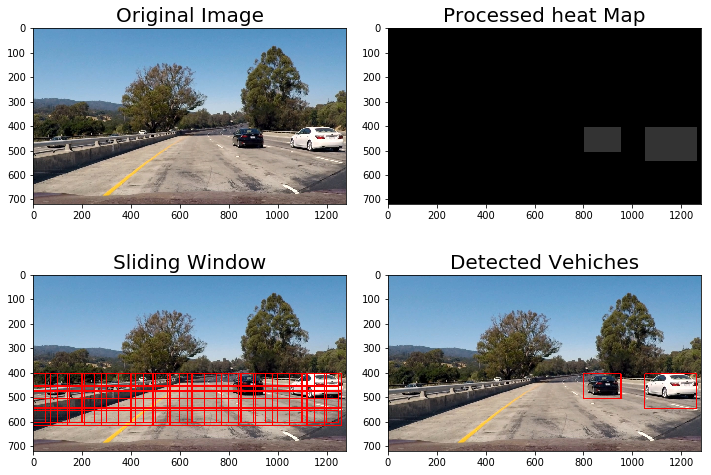

In [6]:
import matplotlib.pyplot as plt

### 1- Load Image
image = scipy.misc.imread('test_images/test1.jpg')

### 2- Process Image
# Heat Map
rectangles = create_rectangles(image)
heat_map = create_heat_map(image, rectangles, clf)
# New Heat Map
filtered_heat_map = heat_map_filter(heat_map, thres_ratio=0.05)
mini_area_1 = detector(filtered_heat_map, area_thres=1000, heat_thres=80)
filtered_heat_map = heat_map_filter(heat_map, thres_ratio=0.05)
mini_area_2 = detector(filtered_heat_map, area_thres=1000, heat_thres=80)
valid_area = distance_filter(mini_area_2, mini_area_1)
new_heat_map = create_new_heat_map(image, valid_area)
# Used Heat Map
used_heat_map = np.zeros_like(image)
decay = 0.05
used_heat_map = used_heat_map*(1-decay)
used_heat_map = (new_heat_map*0.2 + used_heat_map*0.8)
# Sliding Windows
grids = draw_rectangles(image, rectangles)
# Detected Vehicles
target_set = detector(new_heat_map, area_thres=1000, heat_thres=100)
detected_rectangles = []
for elem in target_set:
    detected_rectangles.append(elem[1])
detected_vehicle = draw_rectangles(image, detected_rectangles)

### 3- Ploting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(used_heat_map.astype(np.uint8))
ax2.set_title('Processed heat Map', fontsize=20)
ax3.imshow(grids)
ax3.set_title('Sliding Window', fontsize=20)
ax4.imshow(detected_vehicle)
ax4.set_title('Detected Vehiches', fontsize=20)
plt.show()

### 4.3 Process Video

In [7]:
from moviepy.editor import VideoFileClip

image = scipy.misc.imread('test_images/test1.jpg')
video_output = 'output_images/processed_project.mp4'
video_clip = VideoFileClip('project_video.mp4')
video_process = video_clip.fl_image(pipeline)
%time video_process.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/processed_project.mp4
[MoviePy] Writing video output_images/processed_project.mp4


100%|███████████████████████████████████▉| 1260/1261 [2:18:59<00:06,  6.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/processed_project.mp4 

Wall time: 2h 19min 2s


In [8]:
from IPython.display import HTML

HTML('''
<video width='480' height='360' controls>
  <source src='{0}'>
</video>
'''.format(video_output))